In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt

from lib.functions import sample_trajectory
from lib.lqr import iLQR
from lib.models.dynamics import LinearDynamics
from lib.models.measurements import GaussianMeasurement
from lib.models.priors import GaussianPrior
from lib.plotters import *

## General Parameters

In [2]:
num_steps = 100

Nx = 2
Nu = 2
Ny = 5

## Create the Generative Model
### Dynamics

In [3]:
# State transition matrix
r = np.random.uniform(0.8, 1.0)
theta = np.random.uniform(0, np.pi/4)
A = r*np.array([[np.cos(theta), -np.sin(theta)],
                [np.sin(theta), np.cos(theta)]])

# Control matrix
B = np.random.uniform(-1.0, 1.0, size=(Nx, Nu))

dynamics = LinearDynamics(Nx, Nu, A, B)

### Measurements

In [4]:
# SNR modulation function
scale = 2.0
freq = 2/num_steps
phi = np.random.uniform(0, 2*np.pi)
modulation_func = lambda t : np.exp(scale*np.sin(2*np.pi*freq*t + phi))

# State readout
C = np.random.uniform(-1.0, 1.0, size=(Ny, Nx))
mean_func = lambda x, t : modulation_func(t)*C@x

# Measurement noise
y_cov = np.diag(np.random.uniform(0.5, 1, size=Ny))

meas_model = GaussianMeasurement(Ny, y_cov, mean_func)

### Priors

In [5]:
# Initial state
x0_prior = GaussianPrior(Nx, np.zeros(Nx), 2*np.eye(Nx))

# Input
u_prior = GaussianPrior(Nu, np.zeros(Nu), 0.5*np.eye(Nu))

## Sample a Trajectory

In [6]:
true_xs, true_us, ys = sample_trajectory(
    dynamics,
    meas_model,
    u_prior,
    x0_prior,
    num_steps
)

## Run iLQR for Inference

In [7]:
ilqr = iLQR(
    dynamics,
    meas_model,
    u_prior,
    x0_prior
)

In [8]:
us_init = [u_prior.sample(t) for t in range(num_steps)]

ilqr_xs, ilqr_us = ilqr(ys, us_init)

## Plot the Results

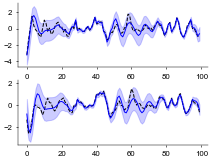

In [9]:
fig, axes = plt.subplots(Nx, 1)

plot_groundtruths(axes, true_xs)
plot_gaussians(axes, ilqr_xs, "b", label="ilqr")
plt.show()

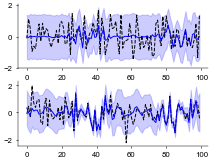

In [10]:
fig, axes = plt.subplots(Nu, 1)

plot_groundtruths(axes, true_us)
plot_gaussians(axes, ilqr_us, "b", label="ilqr")
plt.show()

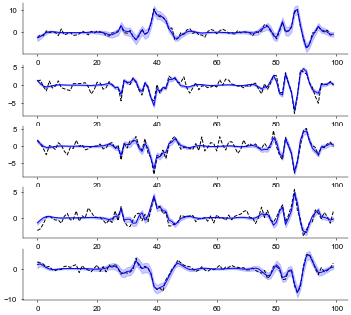

In [11]:
fig, axes = plt.subplots(Ny, 1, figsize=(6, 0.5+Ny))

plot_groundtruths(axes, ys)
plot_measurements(axes, meas_model, ilqr_xs, "b", label="ilqr")
plt.show()